# Real Option Valuation of a Bitcoin Mining Farm

### Hedged Monte-Carlo (HMC) / Least-Squares Monte-Carlo (LSMC) Method
    
This notebook implements the real option valuation model described in the paper **Investments in Bitcoin Mining Farms: Hedged Monte-Carlo Method**.
    
The primary goal is to determine the value of the option to invest in a Bitcoin mining farm. This approach is superior to a simple Net Present Value (NPV) analysis because it quantifies the value of **flexibility**—that is, the ability to delay the investment decision until market conditions are more favorable.
    
The notebook is divided into four main parts:
1. **Monte Carlo Simulation:** We simulate thousands of future paths for the key uncertain variables: the price of Bitcoin ($X_t$) and the price of electricity ($Y_t$).
2. **Intrinsic Value Calculation:** We calculate the project's cash flows and its immediate exercise value (intrinsic value) for each simulated path.
3. **Real Option Valuation:** We use a backward induction algorithm (Least-Squares Monte Carlo) to calculate the option's value at each point in time, which includes the value of waiting.
4. **Analysis of Results:** We visualize the final option value and the probability of exercising the investment option over time.

## 1. Setup and Environment Configuration

In [1]:
### Mount Google Drive

In [1]:
# This notebook is designed to run in Google Colab.
# 1. Mount Google Drive to access utility files
# from google.colab import drive
# drive.mount('/content/drive')

# 2. Add the project folder to Python's path
import sys
import os

In [2]:
# # --- IMPORTANT: CHANGE THIS PATH TO MATCH YOUR PROJECT'S LOCATION ---
# project_path = '/content/drive/Shareddrives/AFMA-HedgeMonteCarlo/HedgeMonteCarlo' # <--- CHANGE THIS PATH
# # -------------------------------------------------------------------

# # Add the path to sys.path if it's not already there
# if project_path not in sys.path:
#     sys.path.append(project_path)

### Libraries

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
# import seaborn as sns

from scipy.stats import norm

# Import custom utility functions for the analysis
# import utils.random_functions as rf
# import utils.options as op
# import utils.optimization as ot

### Functions

#### Simulations

In [4]:
def multivariate_brownian_motion(s0, mu, sigma, dt, num_steps, nscenarios):
  """
  Generates multivariate Brownian motion.

  Args:
      s0: Initial asset prices.
      mu: A NumPy array representing the drift vector (mean returns).
      sigma: A NumPy array representing the covariance matrix of returns.
      dt: The time step.
      num_steps: The number of time steps to simulate.
      nscenarios: The number of scenarios to simulate

  Returns:
      A NumPy array where each row represents a time step and each column
      represents an asset price.
  """

  num_assets = len(mu)  # Number of assets

  prices = np.zeros((nscenarios, num_steps + 1, num_assets))

  for scenario in range(nscenarios):
      # Initialize the price matrix with starting values
      prices[scenario, 0, :] = s0

      # Generate random numbers for each asset at each time step
      Z = np.random.normal(size=(num_steps, num_assets))

      L = np.linalg.cholesky(sigma)  # Cholesky decomposition of the covariance matrix

      for t in range(num_steps):
          dW = L @ Z[t] * np.sqrt(dt) # Generate correlated Brownian motion increments
          prices[scenario, t + 1, :] = prices[scenario, t, :] * np.exp((mu - 0.5 * np.diag(sigma)) * dt + dW)
  return prices


#### Options

##### Margrabe

In [5]:
def margrabe_exchange_option_price(Sx, Sy, sigma_x, sigma_y, qx, qy, rho, r, T):
  """
    Calculate the price of an exchange option using Margrabe's formula.

    Parameters:
    Sx : float - Price of asset X
    Sy : float - Price of asset Y

    Returns:
      price : float - Value of the exchange option
  """

  sigma = np.sqrt(sigma_x**2 + sigma_y**2 - 2 * rho * sigma_x * sigma_y)
  d1 = (np.log(Sx / Sy) + (qy - qx + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  Sx_disc = Sx * np.exp(-qx * T)
  Sy_disc = Sy * np.exp(-qy * T)
  price = Sx_disc * norm.cdf(d1) - Sy_disc * norm.cdf(d2)
  return price

def margrabe_exchange_option_delta(Sx, Sy, sigma_x, sigma_y, qx, qy, rho, r, T):
  """
    Calculate the price of an exchange option using Margrabe's formula.

    Parameters:
    Sx : float - Price of asset X
    Sy : float - Price of asset Y

    Returns:
      price : float - Value of the exchange option
  """

  sigma = np.sqrt(sigma_x**2 + sigma_y**2 - 2 * rho * sigma_x * sigma_y)
  d1 = (np.log(Sx / Sy) + (qy - qx + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)

  delta_x = np.exp(-qx * T) * norm.cdf(d1)
  delta_y = np.exp(-qy * T) * norm.cdf(d2)

  return delta_x, delta_y

##### Black Scholes

In [6]:

def blsprice(price, strike, rate, time, volatility):
    """
    price: Spot price of the underlying asset
    strike: Strike price
    rate: Risk-free interest rate
    time: Time to expiration
    volatility: Volatility of the asset
    
    Returns:
      Call option price calculated using the Black-Scholes formula.
    """
    d1 = (np.log(price / strike) + (rate + 0.5 * volatility**2) * time) / (volatility * np.sqrt(time))
    d2 = d1 - volatility * np.sqrt(time)
    
    call_price = price * norm.cdf(d1) - strike * np.exp(-rate * time) * norm.cdf(d2)
    
    return call_price

def blsdelta(price, strike, rate, time, volatility):
    """
    Calculate the delta of a call and put option using the Black-Scholes formula.

    Inputs:
        price: Current price of the underlying asset.
        strike: Strike (exercise) price of the option.
        rate: Continuously compounded risk-free rate of return over the life of the option.
        time: Time to expiration of the option, expressed in years.
        volatility: Annualized asset price volatility (standard deviation of return), expressed as a positive decimal.

    Outputs:
        dCdS: Delta of the call option.
        dPdS: Delta of the put option.
    """
    # Calculate d1, which is used to find the option delta
    d1 = (np.log(price / strike) + (rate + 0.5 * volatility**2) * time) / (volatility * np.sqrt(time))

    # Calculate N(d1), the CDF of the standard normal distribution at d1
    N1 = norm.cdf(d1)

    # Delta of the call option
    dCdS = N1

    # # Delta of the put option
    # dPdS = N1 - 1

    return dCdS


In [7]:
def black_scholes_call_theta(S, K, T, r, sigma):
    """
    Calculate the theta (time decay) of a European call option using the Black-Scholes model.

    Theta measures the sensitivity of the option price to the passage of time (i.e., how much the option's price declines as expiration approaches).

    Parameters:
        S (float): Current price of the underlying asset.
        K (float): Strike price of the option.
        T (float): Time to expiration in years (for example, 0.5 represents six months).
        r (float): Annual risk-free interest rate (expressed as a decimal).
        sigma (float): Volatility of the underlying asset (expressed as a decimal).

    Returns:
        float: The call option theta (time decay) per year.
    """
    # Calculate d1 and d2 using the Black-Scholes formulas
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate each term of the theta formula
    term1 = - (S * sigma * norm.pdf(d1)) / (2 * np.sqrt(T))
    term2 = - r * K * np.exp(-r * T) * norm.cdf(d2)

    theta = term1 + term2
    return theta

In [8]:
# df_call_option_price = black_scholes_call(df_project_value[[date]], K, delta_time, rho, sigma_present_value)

def black_scholes_call(price, strike, T, rho, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes model.

    Parameters:
        S (float): Current price of the underlying asset.
        K (float): Strike price of the option.
        T (float): Time to expiration in years (e.g., 0.5 for half a year).
        r (float): Annual risk-free interest rate (as a decimal).
        sigma (float): Volatility of the underlying asset (as a decimal).

    Returns:
        float: Call option price.
    """
    # Calculate d1 and d2 using the Black-Scholes formulas
    d1 = (np.log(price / strike) + (rho + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Compute the option price using the standard normal cumulative distribution function
    call_price = price * norm.cdf(d1) - strike * np.exp(-rho * T) * norm.cdf(d2)
    return call_price

In [9]:
def black_scholes_call_delta(S, K, T, r, sigma):
    """
    Calculate the delta of a European call option using the Black-Scholes model.

    Parameters:
        S (float): Current price of the underlying asset.
        K (float): Strike price of the option.
        T (float): Time to expiration in years (e.g., 0.5 for half a year).
        r (float): Annual risk-free interest rate (as a decimal).
        sigma (float): Volatility of the underlying asset (as a decimal).

    Returns:
        float: Call option delta.
    """
    # Calculate d1 as in the Black-Scholes formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    # For a call option, delta is the cumulative distribution function (CDF) evaluated at d1
    delta = norm.cdf(d1)
    return delta

#### Basis Functions

In [10]:
# base_bs(df_prices, df_return, delta_time, rho, kappa)

def base_bs(df_prices, df_return, delta_t, r, kappa, basis_type=None):
  """
  df_prices: Underlying assets (scenarios x assets) at a single time point
  investment: Strike price
  r: Mean of the log of the underlying asset
  expiration_time: Time until the option expires

  Returns:
  df_base: A matrix that serves as a base for option pricing
  """

  df_ret_std = df_return.std()
  df_ret_cor = df_return.corr()
  df_ret_mean = df_return.mean()

  df_mean = df_prices.mean()

  assets = {}
  for i, asset in enumerate(df_prices.columns):
    assets[i] = asset

  if basis_type is None:
    basis_type = {'pol_order': 2}
    basis_type['option_basis'] = 0

  df_base = pd.DataFrame([], index=df_prices.index)
  df_base['call_po_0'] = 1

  for asset in df_prices.columns:
    for order in range(1, basis_type['pol_order'] + 1):
      df_base[f'call_po_{order}_{asset}'] = (df_prices[asset] - df_mean[asset]) ** order

  if basis_type['option_basis'] == 'black-scholes':
    for asset in df_prices.columns:
      df_base['call_option'] = blsprice(df_prices[asset], df_mean[asset], r, delta_t, df_ret_std[asset])
  elif basis_type['option_basis'] == 'margrabe':
    kappa_aux = df_prices[assets[0]].mean() / df_prices[assets[1]].mean()

    df_base['call_option'] = margrabe_exchange_option_price(df_prices[assets[0]], kappa_aux * df_prices[assets[1]], \
                                                                   df_ret_std[assets[0]], kappa_aux * df_ret_std[assets[1]], \
                                                                   df_ret_mean[assets[0]], df_ret_mean[assets[1]], \
                                                                   corr, r, delta_t)
  return df_base

def base_bs_delta(df_prices, df_return, delta_t, r, kappa, basis_type=None):
  """
  df_prices: Underlying assets (scenarios x assets) at a single time point
  investment: Strike price
  r: Mean of the log of the underlying asset
  expiration_time: Time until the option expires

  Returns:
  df_base: A matrix that serves as a base for option pricing
  """

  df_ret_std = df_return.std()
  df_ret_cor = df_return.corr()
  df_ret_mean = df_return.mean()

  df_mean = df_prices.mean()

  if basis_type is None:
    basis_type = {'pol_order': 2}
    basis_type['option_basis'] = 0

  assets = {}
  for i, asset in enumerate(df_prices.columns):
    assets[i] = asset

  df_base = pd.DataFrame([], index=df_prices.index)
  for asset in df_prices.columns: # Fix: Populate assets dictionary correctly
    for order in range(basis_type['pol_order']):
      df_base[f'dl_po_{order}_{asset}'] = (df_prices[asset] - df_mean[asset]) ** order
      df_base[f'dl_po_{order}_{asset}'] *= df_return[asset]

  if basis_type['option_basis'] == 'black-scholes':
    for asset in df_prices.columns:
      df_base[f'dl_option_{asset}'] = blsdelta(df_prices[asset], df_mean[asset], r, delta_t, df_ret_std[asset])
      df_base[f'dl_option_{asset}'] *= df_return[asset]
  elif basis_type['option_basis'] == 'margrabe':
    kappa_aux = df_prices[assets[0]].mean() / df_prices[assets[1]].mean()
    delta_x, delta_y = margrabe_exchange_option_delta(df_prices[assets[0]], kappa_aux * df_prices[assets[1]], \
                                                                   df_ret_std[assets[0]], kappa_aux * df_ret_std[assets[1]], \
                                                                   df_ret_mean[assets[0]], df_ret_mean[assets[1]], \
                                                                   corr, r, delta_t)
    df_base[f'dl_option_{assets[0]}'] = delta_x * df_return[assets[0]]
    df_base[f'dl_option_{assets[1]}'] = delta_y * df_return[assets[1]]

  return df_base

### Optimization

In [11]:
def optimization(df_m, df_c):
  mt_c = np.matrix(df_c)
  mt_m = np.matrix(df_m)
  mt_delta = np.linalg.inv(mt_m.T @ mt_m) @ (mt_m.T @ mt_c)
  mt_res_aux = mt_m @ mt_delta - mt_c
  opt_value = mt_res_aux.T @ mt_res_aux
  return mt_delta, opt_value

#### G functions

In [12]:
def calculate_g_montecarlo(x0, y0, pm_prices, pm_investment, pm_others):
  kappa = pm_investment['kappa']
  k = pm_investment['k']
  K = pm_investment['K']

  rho = pm_others['rho']
  duration_project = pm_others['duration_project']
  delta_time = pm_others['delta_time']

  x_ret = np.matrix(pm_prices['x_ret'])
  y_ret = np.matrix(pm_prices['y_ret'])

  g_value = 0

  for i_aux in range(1, duration_project + 1):
    x_ret_aux = x_ret[:, :i_aux].sum(axis=1)
    y_ret_aux = y_ret[:, :i_aux].sum(axis=1)

    g_aux = x0 * np.exp(x_ret_aux) - kappa * y0 * np.exp(y_ret_aux)
    g_aux[g_aux < 0] = 0
    g_aux -= k
    g_aux *= np.exp(-rho * i_aux * delta_time)
    g_value += g_aux.mean()

  return float(g_value) - K

def calculate_g_margrabe(x0, y0, pm_prices, pm_investment, pm_others):

    """
    Sum of exchange option prices over discrete maturities minus discounted fixed payments and initial payment.

    Parameters:
    X0 : float - Initial price of asset X
    Y0 : float - Initial price of asset Y

    Returns:
    total_value : float - Adjusted sum of exchange option prices minus payments
    """
    kappa = pm_investment['kappa']
    k = pm_investment['k']
    K = pm_investment['K']

    rho = pm_others['rho']
    duration_project = pm_others['duration_project']
    delta_time = pm_others['delta_time']

    sigma_x = pm_prices['sigma_x']
    sigma_y = pm_prices['sigma_y']
    corr = pm_prices['corr']
    qx = pm_prices['qx']
    qy = pm_prices['qy']

    total_option_price = 0.0
    for i in range(1, duration_project + 1):
        t_i = i * delta_time
        option_price = margrabe_exchange_option_price(
            x0, kappa * y0, sigma_x, kappa * sigma_y, qx, qy, corr, rho, t_i)
        # Present value of fixed payment k at time t_i
        pv_fixed_payment = k * np.exp(-rho * t_i)
        total_option_price += option_price - pv_fixed_payment
    # Subtract time-zero payment K
    total_value = total_option_price - K
    return total_value

def calculate_g_vectorized(prices, pm_prices, pm_investment, pm_others):

  ## Optimized Code
  X = prices['X']
  Y = prices['Y']

  # 1. Pre-computation of Forward-Looking Returns (Unchanged)
  X_ret = np.log(X).diff(axis=1)
  Y_ret = np.log(Y).diff(axis=1)

  # X_ret = pm_prices['x_ret'].T
  # Y_ret = pm_prices['y_ret'].T

  kappa = pm_investment['kappa']
  k = pm_investment['k']
  K = pm_investment['K']

  rho = pm_others['rho']
  duration_project = pm_others['duration_project']
  delta_time = pm_others['delta_time']

  X_ret_acum = {i: X_ret.T.rolling(i, min_periods=i).sum().shift(-i).T
                for i in range(1, duration_project + 1)}
  Y_ret_acum = {i: Y_ret.T.rolling(i, min_periods=i).sum().shift(-i).T
                for i in range(1, duration_project + 1)}

  # 2. Vectorized Main Calculation
  # Convert DataFrames to NumPy arrays for maximum performance.
  X_val = X.values
  Y_val = Y.values

  # Initialize the final result array with zeros.
  G_val_sum = np.zeros_like(X_val)

  # Reshape price arrays to enable broadcasting.
  # This adds a new dimension, changing the shape from (scenarios, dates)
  # to (1, scenarios, dates).
  X_broadcast = X_val[np.newaxis, :, :]
  Y_broadcast = Y_val[np.newaxis, :, :]

  # This loop over a small integer range is perfectly fine.
  for t in range(1, duration_project + 1):
      # Get the pre-computed return arrays for the current duration 't'.
      X_ret_t = np.exp(X_ret_acum[t].values)
      Y_ret_t = np.exp(Y_ret_acum[t].values)

      # X_ret_t = X_ret_acum[t].values
      # Y_ret_t = Y_ret_acum[t].values

      # Reshape return arrays. This changes the shape from (scenarios, dates)
      # to (scenarios, 1, dates).
      X_ret_broadcast = X_ret_t[:, np.newaxis, :]
      Y_ret_broadcast = Y_ret_t[:, np.newaxis, :]

      # --- Core Calculation with Broadcasting ---
      # NumPy automatically expands the dimensions to match, creating a
      # 3D tensor of shape (scenarios, scenarios, dates) without the memory
      # overhead of actually creating the intermediate large arrays.
      g_tensor = (X_broadcast * X_ret_broadcast - kappa * Y_broadcast * Y_ret_broadcast)

      # Apply clipping (max(0, value)) and subtract the constant k.
      g_tensor = np.maximum(g_tensor, 0)
      g_tensor -= k

      # Calculate the mean along axis=0. This collapses the 3D tensor
      # into a 2D matrix of shape (scenarios, dates), effectively performing
      # the mean calculation for every (scenario, date) cell in one step.
      g_t_matrix = g_tensor.mean(axis=0)
      g_t_matrix *= np.exp(-rho * t * delta_time)

      # Add the result for duration 'i' to our total sum.
      G_val_sum += g_t_matrix

  # 3. Apply Discount Factor
  # The discount factor is multiplied at the end, which is mathematically
  # equivalent to multiplying it inside the loop, but more efficient.
  G_val_final = G_val_sum

  # 4. Convert Result Back to a DataFrame
  # Create the final DataFrame with the original index and columns.
  G = pd.DataFrame(G_val_final, index=X.index, columns=X.columns)
  # G /= n_days
  G.dropna(axis=1, inplace=True)
  return G

## Preprocess and Parameters

### 2. Monte Carlo Simulation of Asset Prices
  
Here, we simulate the future price paths for Bitcoin ($X_t$) and Electricity ($Y_t$) under the **real-world measure $\\mathbb{P}$**, as discussed in Section 2.2 of the paper. We use a multivariable geometric Brownian motion model, which accounts for the assets' expected returns (`mu`), volatilities, and their correlation (`cov_matrix`). This generates `num_simulations` (1000) possible future scenarios for our valuation.

#### Define Project and Valuation Timeframes

- **Valuation Date:** The date of the analysis (today, $t=0$).
- **Start/End Date:** The investment horizon $[0, T]$ during which the option can be exercised.
- **Duration Project:** The lifetime of the mining farm once built ($T'$ in the paper)."

#### Economic Parameters for Cash Flow Calculation
These parameters correspond to the variables in the cash flow formula from the paper: **$(X_t - \kappa Y_t)^{+} - k$**.

- `rho`: Discount factor rate ($\\rho$).
- `k`: Additional fixed operational costs ($k$).
- `kappa`: Conversion factor for electricity needed to mine 1 BTC ($\kappa$).
- `investment`: The initial sunk cost to build the farm ($K$)."

## Parameters



### Simulation Parameters

In [13]:
# --- Simulation Parameters ---
# Note: These are placeholder values. For a real analysis, they should be derived from historical data.
num_assets = 2 # Simulating two variables: Bitcoin (price_0) and Energy (price_1)
initial_prices = np.array([100, 80]) # Placeholder initial prices for X_t and Y_t

qx = 0.02           # Dividend yield of asset X
qy = 0.01           # Dividend yield of asset Y
mu = np.array([qx, qy]) # Annualized expected returns (drift)

# mu = np.array([0.08, 0.05]) # Annualized expected returns (drift)
# Fixed parameters: can be adjusted as needed
sigma_x = 0.25      # Volatility of asset X
sigma_y = 0.30      # Volatility of asset Y
corr = -0.7      # Correlation between asset X and Y returns

cov_matrix = np.array([
    [sigma_x**2, corr*sigma_x*sigma_y], # Annualized covariance matrix (volatility and correlation)
    [corr*sigma_x*sigma_y, sigma_y**2]
  ])

pm_prices = {
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'corr': corr,
    'qx': qx,
    'qy': qy
  }

### Project cost

In [14]:
k = 0.5 # Fixed costs
K = 860       # Initial time-zero payment
kappa = 0.9 # Electricity conversion factor

pm_investment = {
    'k': k,
    'K': K,
    'kappa': kappa
  }

### Project Duration

In [15]:
n_days = 365  # Number of trading days in a year
T = 0.5           # Total maturity in years

# Number of steps for the random walk
num_steps = int(T * n_days) + 1 # Using the projection_days from the preceding code
delta_time = 1 / n_days # Time step (Δ)

### Parameters Dates

In [16]:
valuation_date = dt.date(2025, 1, 1)
start_date = dt.date(2025, 2, 1)
end_date = dt.date(2025, 5, 1)
duration_project = 31 # Lifetime of the project in days (T')
dates = pd.date_range(start=valuation_date, end=end_date)

### Others Parameters

In [17]:
num_simulations = 1200 # Number of simulations (M in the paper)
rho = 0.02            # Risk-free interest rate (discount factor)
pm_others = {
    'rho': rho,
    'duration_project': duration_project,
    'delta_time': delta_time
  }

## Simulations and Preprocessing

### Prices Simulations

In [19]:
# Load simulations from file
file_name = 'multivariate_simulations.npz'
print(f"Loading simulations from {file_name}...")
loaded_data = np.load(file_name)
simulations = {key: loaded_data[key] for key in loaded_data}

# Extract arrays
btc_sims = simulations['btc']
elec_sims = simulations['electricity']

# Update num_simulations and num_steps based on loaded data
num_simulations = btc_sims.shape[0]
num_steps = btc_sims.shape[1] - 1 # -1 because shape includes initial price
print(f"Loaded {num_simulations} simulations with {num_steps} time steps.")

# Store prices in a dictionary of DataFrames for easy access
prices = {}
# BTC (X_t)
# Ensure we only take the columns corresponding to the dates we have
prices['X'] = pd.DataFrame(btc_sims[:, :len(dates)], columns=dates)
# Energy (Y_t)
prices['Y'] = pd.DataFrame(elec_sims[:, :len(dates)], columns=dates)

returns = {}
for price in prices:
  returns[price] = np.log(prices[price].T).diff().T
  returns[price].dropna(axis=1, inplace=True)

pm_prices['x_ret'] = returns['X']
pm_prices['y_ret'] = returns['Y']

Loading simulations from multivariate_simulations.npz...
Loaded 10000 simulations with 366 time steps.


c:\Users\fe_ma\miniconda3\envs\mchedge\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\fe_ma\miniconda3\envs\mchedge\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


### 3. Calculation of Project Cash Flows and Intrinsic Value

In this section, we calculate the project's Net Present Value ($G(x,y)$) for every possible investment day in each simulation, as defined in **Equation 2.1** and approximated in **Equation 2.2** of the paper.

This value represents the total profit if the investment were made on that specific day. It is the **\"immediate exercise value\"** or **\"intrinsic value\"** of the real option.

\begin{equation}
G(x,y)\approx\frac{h}{N}\sum_{n=1}^N \sum_{i=1}^J e^{-\rho t_i}\left( \left(X^{(n)}_{t_i}-\kappa Y^{(n)}_{t_i}\right)^+-k\right)-K
\end{equation}

### Test G values

In [21]:
# prices
import random
b = []
A = []
for _ in range(2000):
  i = random.choice(range(num_simulations))
  date = random.choice(prices['X'].columns)
  x0 = prices['X'].loc[i][date]
  y0 = prices['Y'].loc[i][date]
  g0 = calculate_g_montecarlo(x0, y0, pm_prices, pm_investment, pm_others)
  v0 = x0 - kappa * y0
  # v0 = x0 - 0.01 * y0
  b.append(g0)
  # A.append([1, v0, v0**2])
  # A.append([1, x0, x0**2, y0, y0**2, x0*y0])
  A.append([1, v0, v0**2, v0**3])

mt_A = np.matrix(A)
mt_b = np.matrix(b).T
mt_A_inv = np.linalg.inv(mt_A.T @ mt_A)
mt_alpha = mt_A_inv @ (mt_A.T @ mt_b)



In [22]:
def calculate_g_tilde(x, y, kappa, mt_alpha):
  v = x - kappa * y
  return mt_alpha[0] + mt_alpha[1] * v + mt_alpha[2] * v**2 + mt_alpha[3] * v**3

In [ ]:
# G = calculate_g_vectorized(prices, pm_prices, pm_investment, pm_others)

In [74]:
# G = pd.DataFrame([], index=prices['X'].index, columns=prices['X'].columns)
# for i in G.index:
#     for date in G.columns:
#         x0 = prices['X'].loc[i][date]
#         y0 = prices['Y'].loc[i][date]
#         G.loc[i, date] = calculate_g_margrabe(x0, y0, pm_prices, pm_investment, pm_others)

In [75]:
# import random

# for _ in range(10):
#   i = random.choice(range(num_simulations))
#   date = random.choice(G.columns)
#   x0 = prices['X'].loc[i][date]
#   y0 = prices['Y'].loc[i][date]
#   print(str(x0).zfill(3), str(y0).zfill(3),
#           G.loc[i][date] - K,
#           calculate_g_margrabe(x0, y0, pm_prices, pm_investment, pm_others),
#           calculate_g_montecarlo(x0, y0, pm_prices, pm_investment, pm_others),
#           )

## 4. Real Option Valuation via Backward Induction (LSMC)

This is the core of the algorithm. We solve the optimal stopping problem from **Equation 2.3** by working backward in time from the option's expiry date.

At each time step $t_j$, we compare:
1. **Intrinsic Value:** The value of exercising immediately, $G(X_{t_j}, Y_{t_j})$.
2. **Continuation Value:** The expected value of holding the option, estimated by regressing the option's value at $t_{j+1}$ against the asset prices at $t_j$. This corresponds to $CV(j, x, y)$ in **Equation 2.5**.

The option's value is then the maximum of these two, as shown in **Equation 2.8**: $V(j, m) = \max(CV, G)$.



### 4.1 Basis Functions
Call options
$$ Call(V_t(k), I, t) = \alpha_0 + \sum_{i=1}^N \left(\alpha_1^i \left(S_t^i(k) - \bar S_t^i \right) + \alpha_2^i \left(S_t^i(k) - \bar S_t^i \right)^2 + \alpha_3^i blsprice(S_t^i(k), \bar S_t^i r, \Delta t, \sigma_i) \right) $$
$$ Delta(V_t(k), I, t) = \beta_0 + \sum_{i=1}^N \left(\beta_1^i \left(S_t^i(k) - \bar S_t^i \right) + \beta_2^i \left(S_t^i(k) - \bar S_t^i \right)^2 + \beta_3^i blsdelta(S_t^i(k), \bar S_t^i r, \Delta t, \sigma_i) \right) $$


In [23]:
# Prepare DataFrames to store the results of the backward induction
# dates_project_window = np.arange(start_date, end_date + dt.timedelta(days=1))
dates_project_window = G.columns

df_project_value = pd.DataFrame([], columns=dates_project_window)
df_option_value = pd.DataFrame([], columns=dates_project_window)
df_call_value = pd.DataFrame([], columns=dates_project_window) # This will store the continuation value
df_intrinsic_value = pd.DataFrame([], columns=dates_project_window)
df_prices_nxt = pd.DataFrame([])

NameError: name 'G' is not defined

In [78]:
# Helper function to get the asset prices for a specific date
def obtain_prices(prices, date):
    df_prices_aux = pd.DataFrame([])
    for price in prices:
        df_prices_aux = pd.concat([df_prices_aux, prices[price][[date]]], axis=1)
    df_prices_aux.columns = list(prices.keys())
    return df_prices_aux

In [165]:
dates_project_window = G.columns

df_project_value = pd.DataFrame([], columns=dates_project_window)
df_option_value = pd.DataFrame([], columns=dates_project_window)
df_call_value = pd.DataFrame([], columns=dates_project_window) # This will store the continuation value
df_intrinsic_value = pd.DataFrame([], columns=dates_project_window)
df_prices_nxt = pd.DataFrame([])

# --- Backward Induction Loop ---
end_date = dates_project_window[-1]
date_nxt = dates_project_window[-1]
date_start = dates_project_window[0]

functional_result = {}
for date in reversed(dates_project_window):
    # print(end_date, date, date_nxt)
    # 1. Calculate the project value (NPV - K) and intrinsic value for the current date
    df_project_value[date] = G[date]
    
    df_intrinsic_value[date] = df_project_value[date].copy() - K
    df_intrinsic_value.loc[df_intrinsic_value[date] < 0, date] = 0 # Intrinsic value cannot be negative

    # 2. Set the terminal condition at the last date (T)
    if date == end_date:
        df_option_value[date] = df_intrinsic_value[date].copy()
        df_call_value[date] = df_option_value[date]
        df_prices_nxt = obtain_prices(prices, date)
    else:
        df_prices = obtain_prices(prices, date)
        discount_factor = np.exp(-rho * delta_time)
        df_delta_prices_hedge = df_prices_nxt * discount_factor - df_prices
        
        # Known option values from the next time step
        df_option_nxt = df_option_value[[date_nxt]].copy() * discount_factor
        df_option_nxt.rename(columns={date_nxt: 'option'}, inplace=True)

        df_delta_present_value = df_project_value[[date_nxt]].copy() * discount_factor
        df_delta_present_value.columns = ['delta_pv']
        df_delta_present_value['delta_pv'] -= df_project_value[date].values

        cov_delta = pd.concat([df_delta_present_value, df_delta_prices_hedge], axis=1).cov()
        # cov_delta = np.cov(np.transpose(np.concatenate())
        sigma_present_value = np.std(np.log(df_project_value[[date_nxt]].values / df_project_value[[date]].values))
        # print(sigma_present_value)
        sigma_present_value /= delta_time 
        # sigma_present_value = df_delta_present_value.std().item()
        # sigma_present_value = cov_delta.iloc[0, 0].item()

        # Calculate the call option price
        # df_call_option_price = black_scholes_call(df_project_value[[date]], K, delta_time, rho, sigma_present_value)
        df_call_option_price = black_scholes_call(df_project_value[[date]], K, delta_time, rho, sigma_present_value)
        
        df_call_delta = black_scholes_call_delta(df_project_value[[date]], K, delta_time, rho, sigma_present_value)
        df_call_theta = black_scholes_call_theta(df_project_value[[date]], K, delta_time, rho, sigma_present_value)

        df_matrix_h = pd.DataFrame([], index=df_call_option_price.index)
        df_matrix_h['constant'] = 1
        df_matrix_h['call_price'] = df_call_option_price.values
        df_matrix_h['call_delta'] = df_call_delta * df_delta_present_value.values
        df_matrix_h['call_theta'] = df_call_theta.values
        # df_matrix_prices_hedge = pd.DataFrame([], columns=df_prices.columns)
        df_matrix_prices_hedge = df_prices * df_delta_prices_hedge
        df_matrix_h = pd.concat([df_matrix_h, df_matrix_prices_hedge], axis=1)
        # df_matrix_h['prices_hedge'] = df_prices.values * df_delta_prices_hedge.values
        
        matrix_h = np.matrix(df_matrix_h)
        option_nxt = np.matrix(df_option_nxt)
        beta = np.linalg.inv(matrix_h.T @ matrix_h) @ (matrix_h.T @ option_nxt)

        call_option_nxt_model = matrix_h @ beta
        call_option_nxt_model[call_option_nxt_model < 0] = 0

        mean_delta_prices = df_delta_prices_hedge.mean(axis=0)

        vector_phi = float(beta[-1, 0]) * (df_prices @ cov_delta[1:, 1:])
        vector_phi += float(beta[2, 0]) * (df_call_delta @ cov_delta[:1, 1:])
        vector_phi = np.transpose(vector_phi)
        phi_t = np.linalg.inv(cov_delta[1:, 1:]) @ vector_phi
        
        call_t = float(beta[0, 0]) * constant
        call_t += float(beta[1, 0]) * df_call_option_price
        call_t += float(beta[2, 0]) * df_call_delta * df_delta_present_value.mean()
        call_t += float(beta[3, 0]) * df_call_theta
        
        for i in range(df_delta_prices_hedge.shape[1]):
          call_t += float(beta[4 + i, 0]) * float(mean_delta_prices[i, 0]) * df_prices[:, i:i+1]
        call_t -= phi_t.T @ mean_delta_prices
        call_t[call_t < 0] = 0
        
        call_option_proj[:, t] = call_t[:, 0].flatten()
        # call_option[:, t] = intrinsic_value[:, t]
        call_option[:, t] = np.maximum(call_option[:, t], call_option_proj[:, t])

        break


In [ ]:
def calculate_ro_version_2(G, K, prices):
    # call_option = np.zeros(G.shape)
    # call_option_proj = np.zeros(G.shape)
    # call_option_proj[:, T] = intrinsic_value[:, T]
    # call_option[:, T] = intrinsic_value[:, T]

    dates_project_window = G.columns
    
    df_project_value = pd.DataFrame([], columns=dates_project_window)
    df_option_value = pd.DataFrame([], columns=dates_project_window)
    df_call_value = pd.DataFrame([], columns=dates_project_window) # This will store the continuation value
    df_intrinsic_value = pd.DataFrame([], columns=dates_project_window)
    df_prices_nxt = pd.DataFrame([])

    # --- Backward Induction Loop ---
    end_date = dates_project_window[-1]
    date_nxt = dates_project_window[-1]
    date_start = dates_project_window[0]

    functional_result = {}
    for date in reversed(dates_project_window):
        # print(end_date, date, date_nxt)
        # 1. Calculate the project value (NPV - K) and intrinsic value for the current date
        df_project_value[date] = G[date]
        
        df_intrinsic_value[date] = df_project_value[date].copy()
        df_intrinsic_value.loc[df_intrinsic_value[date] < 0, date] = 0 # Intrinsic value cannot be negative
        
        # 2. Set the terminal condition at the last date (T)
        if date == end_date:
            df_option_value[date] = df_intrinsic_value[date].copy()
            df_call_value[date] = df_option_value[date]
            df_prices_nxt = obtain_prices(prices, date)
        else:
            df_prices = obtain_prices(prices, date)
            discount_factor = np.exp(-rho * delta_time)
            df_delta_prices_hedge = df_prices_nxt * discount_factor - df_prices
            
            # Known option values from the next time step
            df_option_nxt = df_option_value[[date_nxt]].copy() * discount_factor
            df_option_nxt.rename(columns={date_nxt: 'option'}, inplace=True)

            df_present_value_nxt = df_project_value[[date_nxt]].copy() * discount_factor
            df_delta_present_value = df_present_value_nxt.values - df_project_value[date].values

            cov_delta = pd.concat([df_delta_present_value, df_delta_prices_hedge], axis=1).cov()
            # cov_delta = np.cov(np.transpose(np.concatenate())
            sigma_present_value = np.sqrt(cov_delta.iloc[0, 0]) * 365

            # Calculate the call option price
            df_call_option_price = black_scholes_call(df_project_value[date], K, delta_time, rho, sigma_present_value)
            df_call_delta = black_scholes_call_delta(df_project_value[date], K, delta_time, rho, sigma_present_value)
            df_call_theta = black_scholes_call_theta(df_project_value[date], K, delta_time, rho, sigma_present_value)

            df_matrix_h = pd.DataFrame([], index=df_call_option_price.index)
            df_matrix_h['constant'] = 1
            df_matrix_h['call_price'] = df_call_option_price.values
            df_matrix_h['call_delta'] = df_call_delta.values * df_delta_present_value.values
            df_matrix_h['call_theta'] = df_call_theta.values
            df_matrix_h['prices_hedge'] = df_prices.values * df_delta_prices_hedge.values
            
            
            matrix_h = np.matrix(df_matrix_h)
            option_nxt = np.matrix(df_option_nxt)
            beta = np.linalg.inv(matrix_h.T @ matrix_h) @ (matrix_h.T @ option_nxt)
            
            call_option_nxt_model = matrix_h @ beta
            call_option_nxt_model[call_option_nxt_model < 0] = 0

            mean_delta_prices = df_delta_prices_hedge.mean(axis=0)
            mean_delta_prices = mean_delta_prices.reshape(-1, 1)
            
            if t == 0:
                vector_phi = cov_delta[:1, 1:]
                # vector_phi = np.transpose(vector_phi)
                phi_t = np.linalg.inv(cov_delta[1:, 1:]) @ vector_phi
                call_t = call_option_tp1.mean() - phi_t.T @ mean_delta_prices
            else:
                vector_phi = float(beta[-1, 0]) * (prices_hedge_t @ cov_delta[1:, 1:])
                vector_phi += float(beta[2, 0]) * (call_delta @ cov_delta[:1, 1:])
                vector_phi = np.transpose(vector_phi)
                phi_t = np.linalg.inv(cov_delta[1:, 1:]) @ vector_phi
                
                call_t = float(beta[0, 0]) * constant
                call_t += float(beta[1, 0]) * call_option_price
                call_t += float(beta[2, 0]) * call_delta * delta_present_value.mean()
                call_t += float(beta[3, 0]) * call_theta
                
                for i in range(delta_prices_hedge.shape[1]):
                  call_t += float(beta[4 + i, 0]) * float(mean_delta_prices[i, 0]) * prices_hedge_t[:, i:i+1]
                call_t -= phi_t.T @ mean_delta_prices
                call_t[call_t < 0] = 0
                
                call_option_proj[:, t] = call_t[:, 0].flatten()
                # call_option[:, t] = intrinsic_value[:, t]
                call_option[:, t] = np.maximum(call_option[:, t], call_option_proj[:, t])

    
# for t in reversed(range(T)):
#   present_value_t = present_value[:, t]
#   present_value_t = present_value_t.reshape(-1, 1)

#   call_option_tp1 = call_option[:, t + 1]
#   call_option_tp1 = call_option_tp1.reshape(-1, 1)

#   prices_hedge_t = prices_hedge[:, t, :]

#   delta_present_value = present_value[:, t+1] - present_value[:, t]
#   delta_present_value = delta_present_value.reshape(-1, 1)

#   delta_prices_hedge = prices_hedge[:, t+1, :] - prices_hedge[:, t, :]

#   cov_delta = np.cov(np.transpose(np.concatenate([delta_present_value, delta_prices_hedge], axis=1)))
#   sigma_present_value = np.sqrt(cov_delta[0, 0]) * 252

#   # Calculate the call option price
#   call_option_price = black_scholes_call(present_value_t, investment, 1/252, r, sigma_present_value)
#   call_delta = black_scholes_call_delta(present_value_t, investment, 1/252, r, sigma_present_value)
#   call_theta = black_scholes_call_theta(present_value_t, investment, 1/252, r, sigma_present_value)

#   constant = np.transpose(np.matrix([1]*len(present_value_t)))
#   cons_rep = np.array(np.repeat(constant, delta_prices_hedge.shape[1], axis=1))
#   # matrix_h = np.concatenate([constant, call_option_price, call_delta * delta_present_value, call_theta, \
#   #                          cons_rep * delta_prices_hedge, prices_hedge_t * delta_prices_hedge,
#   #                            (prices_hedge_t ** 2) * delta_prices_hedge], axis=1)
#   #                           #  prices_hedge_t * delta_prices_hedge,
#                             # (prices_hedge_t ** 2) * delta_prices_hedge], axis=1)

#   matrix_h = np.concatenate([constant, call_option_price, call_delta * delta_present_value, call_theta, \
#                             prices_hedge_t * delta_prices_hedge], axis=1)

#   beta = np.linalg.inv(matrix_h.T @ matrix_h) @ (matrix_h.T @ call_option_tp1)
#   call_option_tp1_model = matrix_h @ beta
#   call_option_tp1_model[call_option_tp1_model < 0] = 0

#   print('-'*25, ':', t)
#   analyze_model_error(call_option_tp1, call_option_tp1_model)

#   mean_delta_prices = delta_prices_hedge.mean(axis=0)
#   mean_delta_prices = mean_delta_prices.reshape(-1, 1)

#   if t == 0:
#     vector_phi = cov_delta[:1, 1:]
#     # vector_phi = np.transpose(vector_phi)
#     phi_t = np.linalg.inv(cov_delta[1:, 1:]) @ vector_phi
#     call_t = call_option_tp1.mean() - phi_t.T @ mean_delta_prices
#   else:
#     vector_phi = float(beta[-1, 0]) * (prices_hedge_t @ cov_delta[1:, 1:])
#     vector_phi += float(beta[2, 0]) * (call_delta @ cov_delta[:1, 1:])
#     vector_phi = np.transpose(vector_phi)
#     phi_t = np.linalg.inv(cov_delta[1:, 1:]) @ vector_phi

#     call_t = float(beta[0, 0]) * constant
#     call_t += float(beta[1, 0]) * call_option_price
#     call_t += float(beta[2, 0]) * call_delta * delta_present_value.mean()
#     call_t += float(beta[3, 0]) * call_theta

#     for i in range(delta_prices_hedge.shape[1]):
#       call_t += float(beta[4 + i, 0]) * float(mean_delta_prices[i, 0]) * prices_hedge_t[:, i:i+1]
#     call_t -= phi_t.T @ mean_delta_prices
#     call_t[call_t < 0] = 0

#   call_option_proj[:, t] = call_t[:, 0].flatten()
#   # call_option[:, t] = intrinsic_value[:, t]
#   call_option[:, t] = np.maximum(call_option[:, t], call_option_proj[:, t])

  # break

    return

In [79]:
def calculate_real_option(G, K, prices, basis_type):
  dates_project_window = G.columns

  df_project_value = pd.DataFrame([], columns=dates_project_window)
  df_option_value = pd.DataFrame([], columns=dates_project_window)
  df_call_value = pd.DataFrame([], columns=dates_project_window) # This will store the continuation value
  df_intrinsic_value = pd.DataFrame([], columns=dates_project_window)
  df_prices_nxt = pd.DataFrame([])

  # --- Backward Induction Loop ---
  end_date = dates_project_window[-1]
  date_nxt = dates_project_window[-1]
  date_start = dates_project_window[0]

  functional_result = {}
  for date in reversed(dates_project_window):
    # print(end_date, date, date_nxt)
    # 1. Calculate the project value (NPV - K) and intrinsic value for the current date
    df_project_value[date] = G[date] - K
    # df_project_value[date] = G[date]
      

    df_intrinsic_value[date] = df_project_value[date].copy()
    df_intrinsic_value.loc[df_intrinsic_value[date] < 0, date] = 0 # Intrinsic value cannot be negative

    # 2. Set the terminal condition at the last date (T)
    if date == end_date:
      df_option_value[date] = df_intrinsic_value[date].copy()
      df_call_value[date] = df_option_value[date]
      df_prices_nxt = obtain_prices(prices, date)

    # 3. For all other dates, calculate the continuation value
    else :
      df_prices = obtain_prices(prices, date)
      discount_factor = np.exp(-rho * delta_time)
      df_return = df_prices_nxt * discount_factor - df_prices

      # Known option values from the next time step
      df_option_nxt = df_option_value[[date_nxt]].copy() * discount_factor
      df_option_nxt.rename(columns={date_nxt: 'option'}, inplace=True)

      prices_std = df_prices.std()

      if prices_std.sum() == 0:
        df_return_aux = pd.concat([df_return, df_option_nxt], axis=1)
        df_return_aux_cov = df_return_aux.cov()
        df_return_cov = df_return_aux_cov.loc[df_return.columns][df_return.columns]
        df_option_cov = df_return_aux_cov.loc[df_return.columns][['option']]
        phi = np.linalg.inv(np.matrix(df_return_cov)) @ np.matrix(df_option_cov)

        option_aux = np.matrix(df_option_nxt) - np.matrix(df_return) @ phi
        option_aux = option_aux.mean()
        option_aux = float(option_aux)

        df_prices_end = obtain_prices(prices, end_date)
        len_proj_end = (end_date - date).days
        discount_factor_end = np.exp(-rho * len_proj_end * delta_time)
        df_return_end = df_prices_end * discount_factor_end - df_prices
        df_option_end = df_option_value[[end_date]] * discount_factor_end
        df_option_end.rename(columns={end_date: 'option'}, inplace=True)

        df_return_aux = pd.concat([df_return_end, df_option_end], axis=1)
        df_return_aux_cov = df_return_aux.cov()
        df_return_cov = df_return_aux_cov.loc[df_return.columns][df_return.columns]
        df_option_cov = df_return_aux_cov.loc[df_return.columns][['option']]
        phi = np.linalg.inv(np.matrix(df_return_cov)) @ np.matrix(df_option_cov)

        option_end = np.matrix(df_option_end) - np.matrix(df_return_end) @ phi
        option_end = option_end.mean()
        option_end = float(option_end)

      else:
        # Create the basis functions (C_a(x,y) in the paper) for the regression
        df_k = base_bs(df_prices, df_return, delta_time, rho, kappa, basis_type).fillna(0)
        df_h = base_bs_delta(df_prices, df_return, delta_time, rho, kappa, basis_type).fillna(0)
        df_m = pd.concat((df_k, df_h), axis=1)

        # Run regression to find coefficients (γ_a^j) and estimate continuation value
        mt_delta, opt_value = optimization(df_m, df_option_nxt)
        functional_result[date] = opt_value
        df_delta = pd.DataFrame(mt_delta, index=df_m.columns)

        option_aux = np.matrix(df_k) @ mt_delta[: df_k.shape[1], :]

      df_call_value[date] = option_aux # Store the continuation value

      # 4. Determine the option value: V = max(Continuation, Intrinsic)
      df_option_value[date] = option_aux
      # df_option_value.loc[df_option_value[date] < df_intrinsic_value[date], date] = df_intrinsic_value[date]

      # Update for the next iteration
      date_nxt = date
      df_prices_nxt = df_prices.copy()

  return df_option_value, df_call_value, df_intrinsic_value, df_delta, functional_result, option_end


## Run Process

In [80]:
functional_results = {}
option_results = {}
intrinsic_results = {}

### Only Polinomial

option_end 12.551411922643126


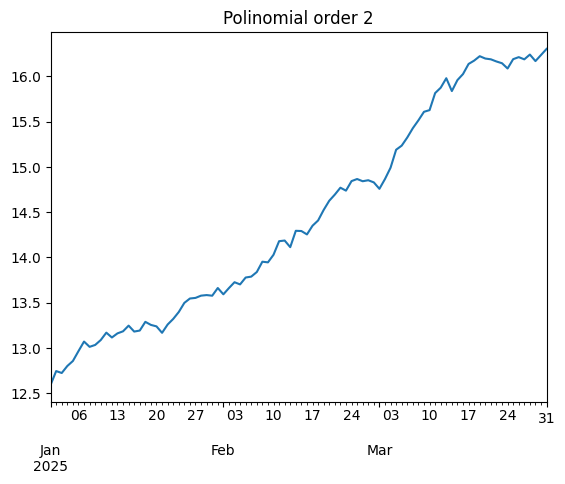

In [81]:
# for i in range(2):
for i in range(1, 2):

  basis_type = {'pol_order': i + 1, 'option_basis': None}
  df_option_value, df_call_value, df_intrinsic_value, df_delta, functional_result, option_end \
    = calculate_real_option(G, K, prices, basis_type)
  functional_results[f'only_polinomial_{i+1}'] = functional_result
  option_results[f'only_polinomial_{i+1}'] = df_option_value
  intrinsic_results[f'only_polinomial_{i+1}'] = df_intrinsic_value
  print('option_end', option_end)
  df_option_value.mean().plot(title=f'Polinomial order {i + 1}')

### Black-Scholes

option_end 12.551411922643126


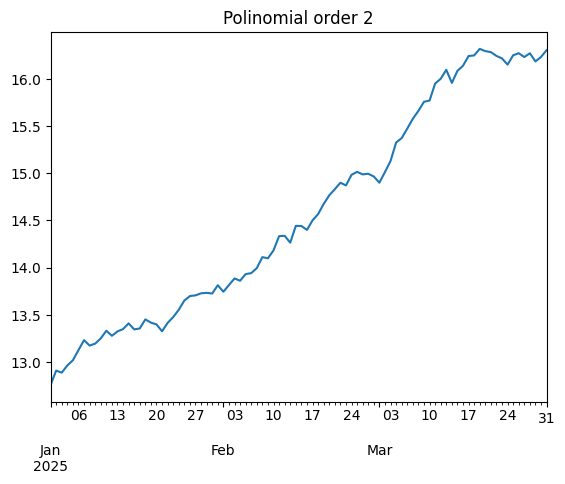

In [82]:
# for i in range(2):
for i in range(1, 2):

  # print(i)
  basis_type = {'pol_order': i + 1, 'option_basis': 'black-scholes'}
  # df_option_value, _, _, df_delta = calculate_real_option(G, K, prices, basis_type)
  # df_option_value, _, _, df_delta, functional_result = calculate_real_option(G, K, prices, basis_type)
  df_option_value, df_call_value, df_intrinsic_value, df_delta, functional_result, option_end \
    = calculate_real_option(G, K, prices, basis_type)
  functional_results[f'black-scholes_{i+1}'] = functional_result
  option_results[f'black-scholes_{i+1}'] = df_option_value
  intrinsic_results[f'black-scholes_{i+1}'] = df_intrinsic_value
  # results[f'black-scholes_{i+1}'] = functional_result
  # print(df_delta)
  print('option_end', option_end)

  # df_option_value.mean().plot(title=f'Polinomial order {i + 1}')

### Margrabe

option_end 12.551411922643126


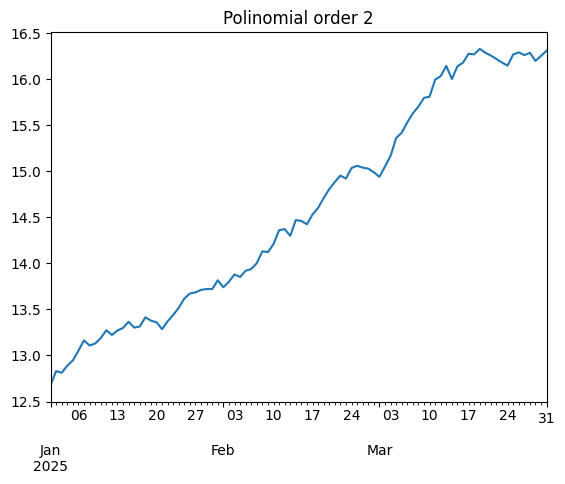

In [83]:
for i in range(1, 2):
# for i in range(2):
  # print(i)
  basis_type = {'pol_order': i + 1, 'option_basis': 'margrabe'}
  # df_option_value, _, _, df_delta = calculate_real_option(G, K, prices, basis_type)
  # df_option_value, _, _, df_delta, functional_result = calculate_real_option(G, K, prices, basis_type)
  df_option_value, df_call_value, df_intrinsic_value, df_delta, functional_result, option_end \
    = calculate_real_option(G, K, prices, basis_type)
  functional_results[f'margrabe_{i+1}'] = functional_result
  option_results[f'margrabe_{i+1}'] = df_option_value
  intrinsic_results[f'margrabe_{i+1}'] = df_intrinsic_value
  # results[f'margrabe_{i+1}'] = functional_result
  # print(df_delta)
  print('option_end', option_end)
    
  # df_option_value.mean().plot(title=f'Polinomial order {i + 1}')

## Results (not ready)

## 5. Analysis of Results

Now we visualize the outcomes of the valuation.
  
### Probability of Early Exercise
This plot shows the probability, at each point in time, that it is optimal to exercise the investment option immediately. This occurs in simulations where the intrinsic value is greater than the continuation value.

In [84]:
for model, result in functional_results.items():
  for date, value in result.items():
    functional_results[model][date] = np.round(value.item(), 1)


,only_polinomial_2,black-scholes_2,margrabe_2
2025-03-30,22533.6,14651.1,3677.6
2025-03-29,11.4,19.0,24.7
2025-03-28,11.1,21.5,25.7
2025-03-27,12.4,21.9,27.4
2025-03-26,10.2,21.8,35.0
...,...,...,...
2025-01-06,10.1,10.9,12.3
2025-01-05,11.4,12.4,14.3
2025-01-04,11.8,12.9,14.6
2025-01-03,11.7,12.3,14.0


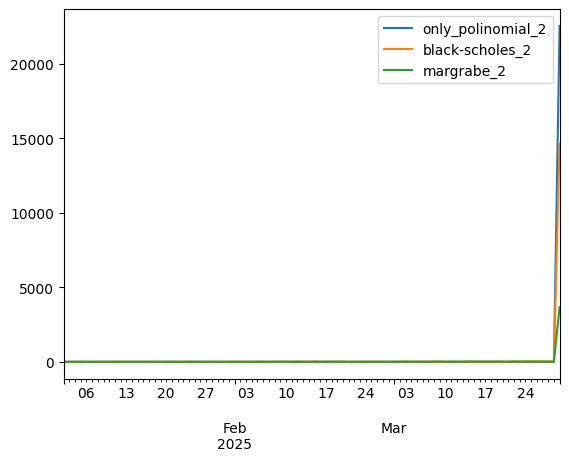

In [85]:

df_results = pd.DataFrame(functional_results)
df_results.plot()
df_results
  # print(model)
  # print(result)

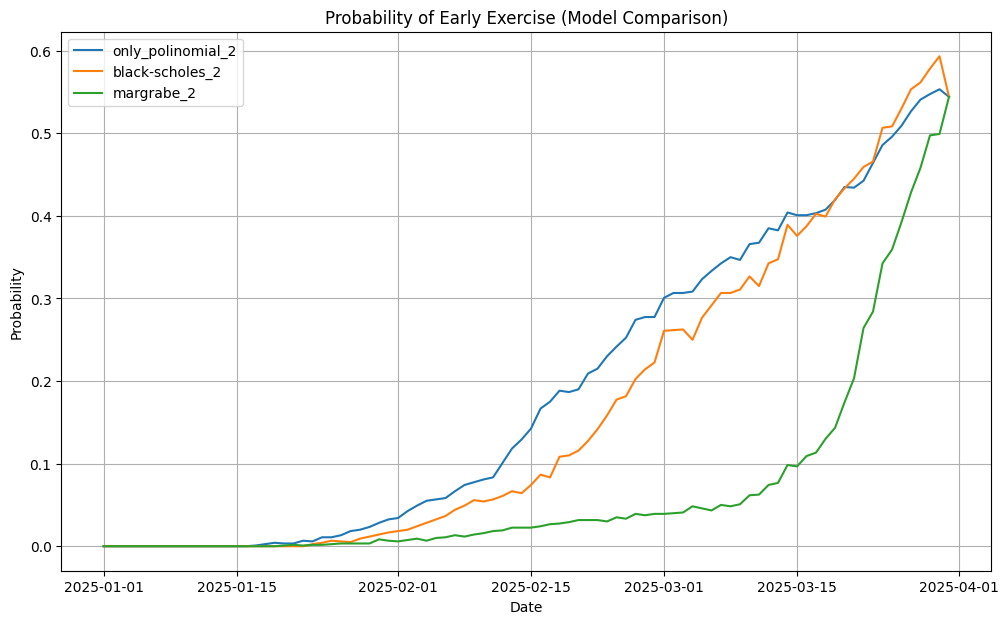

only_polinomial_2 12.591148805301088
black-scholes_2 12.757554712299282
margrabe_2 12.681053308175581


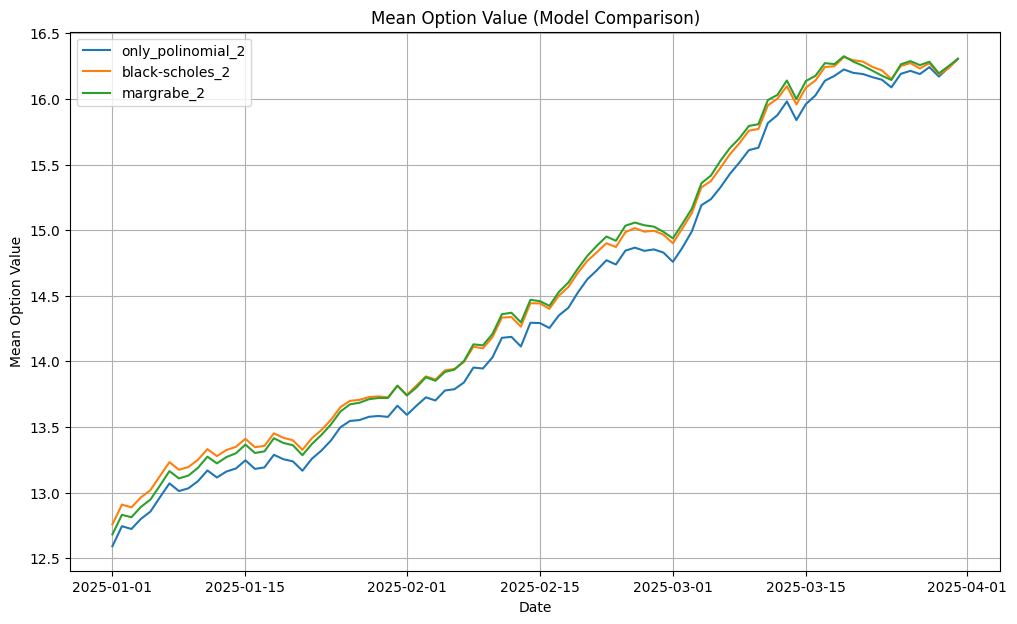

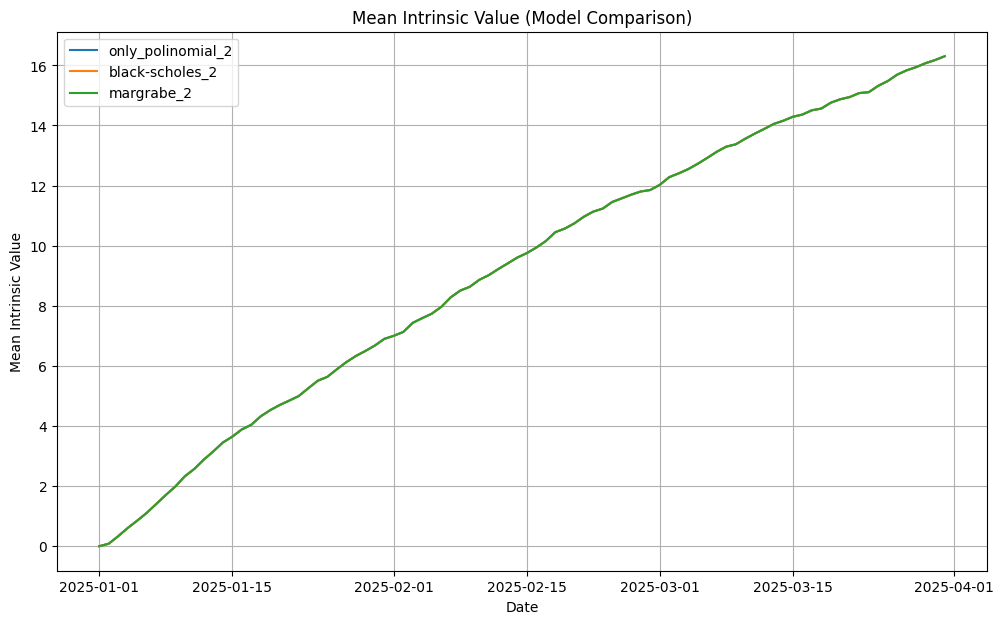

In [86]:
import matplotlib.pyplot as plt

models = ['only_polinomial_2', 'black-scholes_2', 'margrabe_2']

# === 1️⃣ Compare Probability of Early Exercise ===
plt.figure(figsize=(12, 7))

for model in models:
    df_option_value = option_results[model]
    df_intrinsic_value = intrinsic_results[model]

    # Compute probability of early exercise
    df_prob_aux = df_option_value.copy() * 0
    df_prob_aux[df_option_value <= df_intrinsic_value] = 1

    date_end = df_prob_aux.columns[-1]
    df_prob_aux[date_end] = (df_intrinsic_value[date_end] > 0).astype(int)

    prob_series = df_prob_aux.sum() / len(df_prob_aux)
    plt.plot(prob_series.index, prob_series.values, label=f'{model}')

plt.title('Probability of Early Exercise (Model Comparison)')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.grid(True)
plt.legend()
plt.show()

# === 2️⃣ Compare Mean Option Value ===
plt.figure(figsize=(12, 7))
df_option_value_results = pd.DataFrame([])
for model in models:
    df_option_value = option_results[model]
    print(model, df_option_value.iloc[0, 0])
    mean_series = df_option_value.mean()
    plt.plot(mean_series.index, mean_series.values, label=f'{model}')

plt.title('Mean Option Value (Model Comparison)')
plt.xlabel('Date')
plt.ylabel('Mean Option Value')
plt.grid(True)
plt.legend()
plt.show()

# === 3️⃣ Compare Mean Intrinsic Value ===
plt.figure(figsize=(12, 7))

for model in models:
    df_intrinsic_value = intrinsic_results[model]
    mean_series = df_intrinsic_value.mean()
    plt.plot(mean_series.index, mean_series.values, label=f'{model}')

plt.title('Mean Intrinsic Value (Model Comparison)')
plt.xlabel('Date')
plt.ylabel('Mean Intrinsic Value')
plt.grid(True)
plt.legend()
plt.show()
